# **1 - LSTM (Long Short-Term Memory)**

Let's load the required libraries in order to run the code:

In [16]:
import os

import pandas as pd
import numpy as np
# import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from src.data_preprocessing import train_test_split
from src.utils import plot_metric_curves

## Load dataset

Now let's load the dataset generated in `0-EDA.ipynb`:

In [2]:
dataset = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.csv")

df = pd.read_csv(dataset, sep=";")
df.head()

,headline,label
0,thirtysomething scientist unveil doomsday cloc...,1
1,dem rep totally nail congress falling short ge...,0
2,eat veggie deliciously different recipe,0
3,inclement weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


## Split data into train and test sets

We need to generate both training and test sets. We will use the 80% of the data for training and the remaining 20% for testing. Moreover, in classification taks it is important to maintain the same proportion of classes in both training and test sets (if not, the model might be affected by it during the training process, and the validation metrics may also be distorted). `scikit-learn` offers the class `StratifiedShuffleSplit` for achieving this, which will be used. We have developed the `train_test_split` function, which is stored in `src/data_preprocessing.py`:

In [3]:
X_train, y_train, X_test, y_test = train_test_split(df, "label")

Let's check the ratio between the training set and the test set is 20% as expected:

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Let's also see the distribution of classes in both sets are almost the same:

In [6]:
y_train.value_counts(normalize=True)

0    0.524518
1    0.475482
Name: label, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

0    0.524469
1    0.475531
Name: label, dtype: float64

As it can be seen, the distribution of classes in both sets is the same, as we expected.

# Tokenization, Padding and Sequencing

***Note***: *in following notebooks the shown steps will be executed directly by using the functions contained in `src/data_preprocessing.py`*.

**Source**: , Bala Priya C. [Tokenization and Sequencing in TensorFlow](https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n)

In [8]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train["headline"])

Let's see the vocabulary size from our tokenizer:

In [9]:
vocab_size = len(tokenizer.word_index)
vocab_size

22498

Once we have tokenized our text, we need to use the generated tokens to convert the headlines into a sequence:

In [10]:
train_sequences = tokenizer.texts_to_sequences(X_train["headline"])
test_sequences = tokenizer.texts_to_sequences(X_test["headline"])

Let's see the first sequences in order to have a better idea of how these look like:

In [11]:
# Original headlines
X_train["headline"].values.tolist()[:3]

['still processing ending walking dead stranger',
 'legionnaire disease kill seven sickens new york city',
 'could family escape house fire time']

In [12]:
# Sequences
train_sequences[:3]

[[32, 8384, 1961, 571, 101, 931],
 [6636, 1138, 213, 4744, 8385, 3, 203, 120],
 [39, 34, 1327, 23, 145, 12]]

As it can be noticed, since each headline has a different length, each sequence has also a different length. This leads to the following issue. In order to feed the data into the neural network, all the sequences must have the same length. Therefore, we will need to apply some kind of transformation to these sequences in order to make them all have the same length.

For doing so, we will apply a technique called **padding**. Similar to what is seen in image processing, we can apply padding to text. In this case, we need to add a certain number of zeros at the beginning or at the end of each sequence, so all of them have the same length. Specifically, the length of the sequences will be the lenght of the largest sequence in the dataset. In our case, we will add zeros at the end of each sequence.

Let's first get the lenght of the largest sequence:

In [13]:
max_seq_len = max([len(seq) for seq in train_sequences])
max_seq_len

106

In [14]:
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

Let's see the first sequences after applying padding, so we can compare these with how they looked like before. Hence, we will understand better the effects of applying padding to our text:

In [15]:
# Sequences after padding
train_padded[:3]

array([[  32, 8384, 1961,  571,  101,  931,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [6636, 1138,  213, 4744, 8385,    3,  203,  120,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

## Build the model

In [17]:
model = Sequential()
model.add(Embedding(vocab_size+1, 100, input_length=max_seq_len))
model.add(Bidirectional(LSTM(128)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [18]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 100)          2249900   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

## Train the model

In [20]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [21]:
# Model name and path
model_path = os.path.join("models", "lstm_model.h5")

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [23]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=20,
    validation_data=(test_padded, np.array(y_test)),
    callbacks = [es, mc]
)

Epoch 1/20
713/713 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.7554
Epoch 1: val_loss improved from inf to 0.40895, saving model to models\lstm_model.h5
713/713 [==============================] - 185s 257ms/step - loss: 0.4828 - accuracy: 0.7554 - val_loss: 0.4090 - val_accuracy: 0.8102
Epoch 2/20
713/713 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9013
Epoch 2: val_loss did not improve from 0.40895
713/713 [==============================] - 226s 316ms/step - loss: 0.2520 - accuracy: 0.9013 - val_loss: 0.4472 - val_accuracy: 0.8051
Epoch 3/20
713/713 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9561
Epoch 3: val_loss did not improve from 0.40895
713/713 [==============================] - 241s 338ms/step - loss: 0.1203 - accuracy: 0.9561 - val_loss: 0.5522 - val_accuracy: 0.7937
Epoch 4/20
713/713 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9759
Epoch 4: val_loss did not improv

## Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

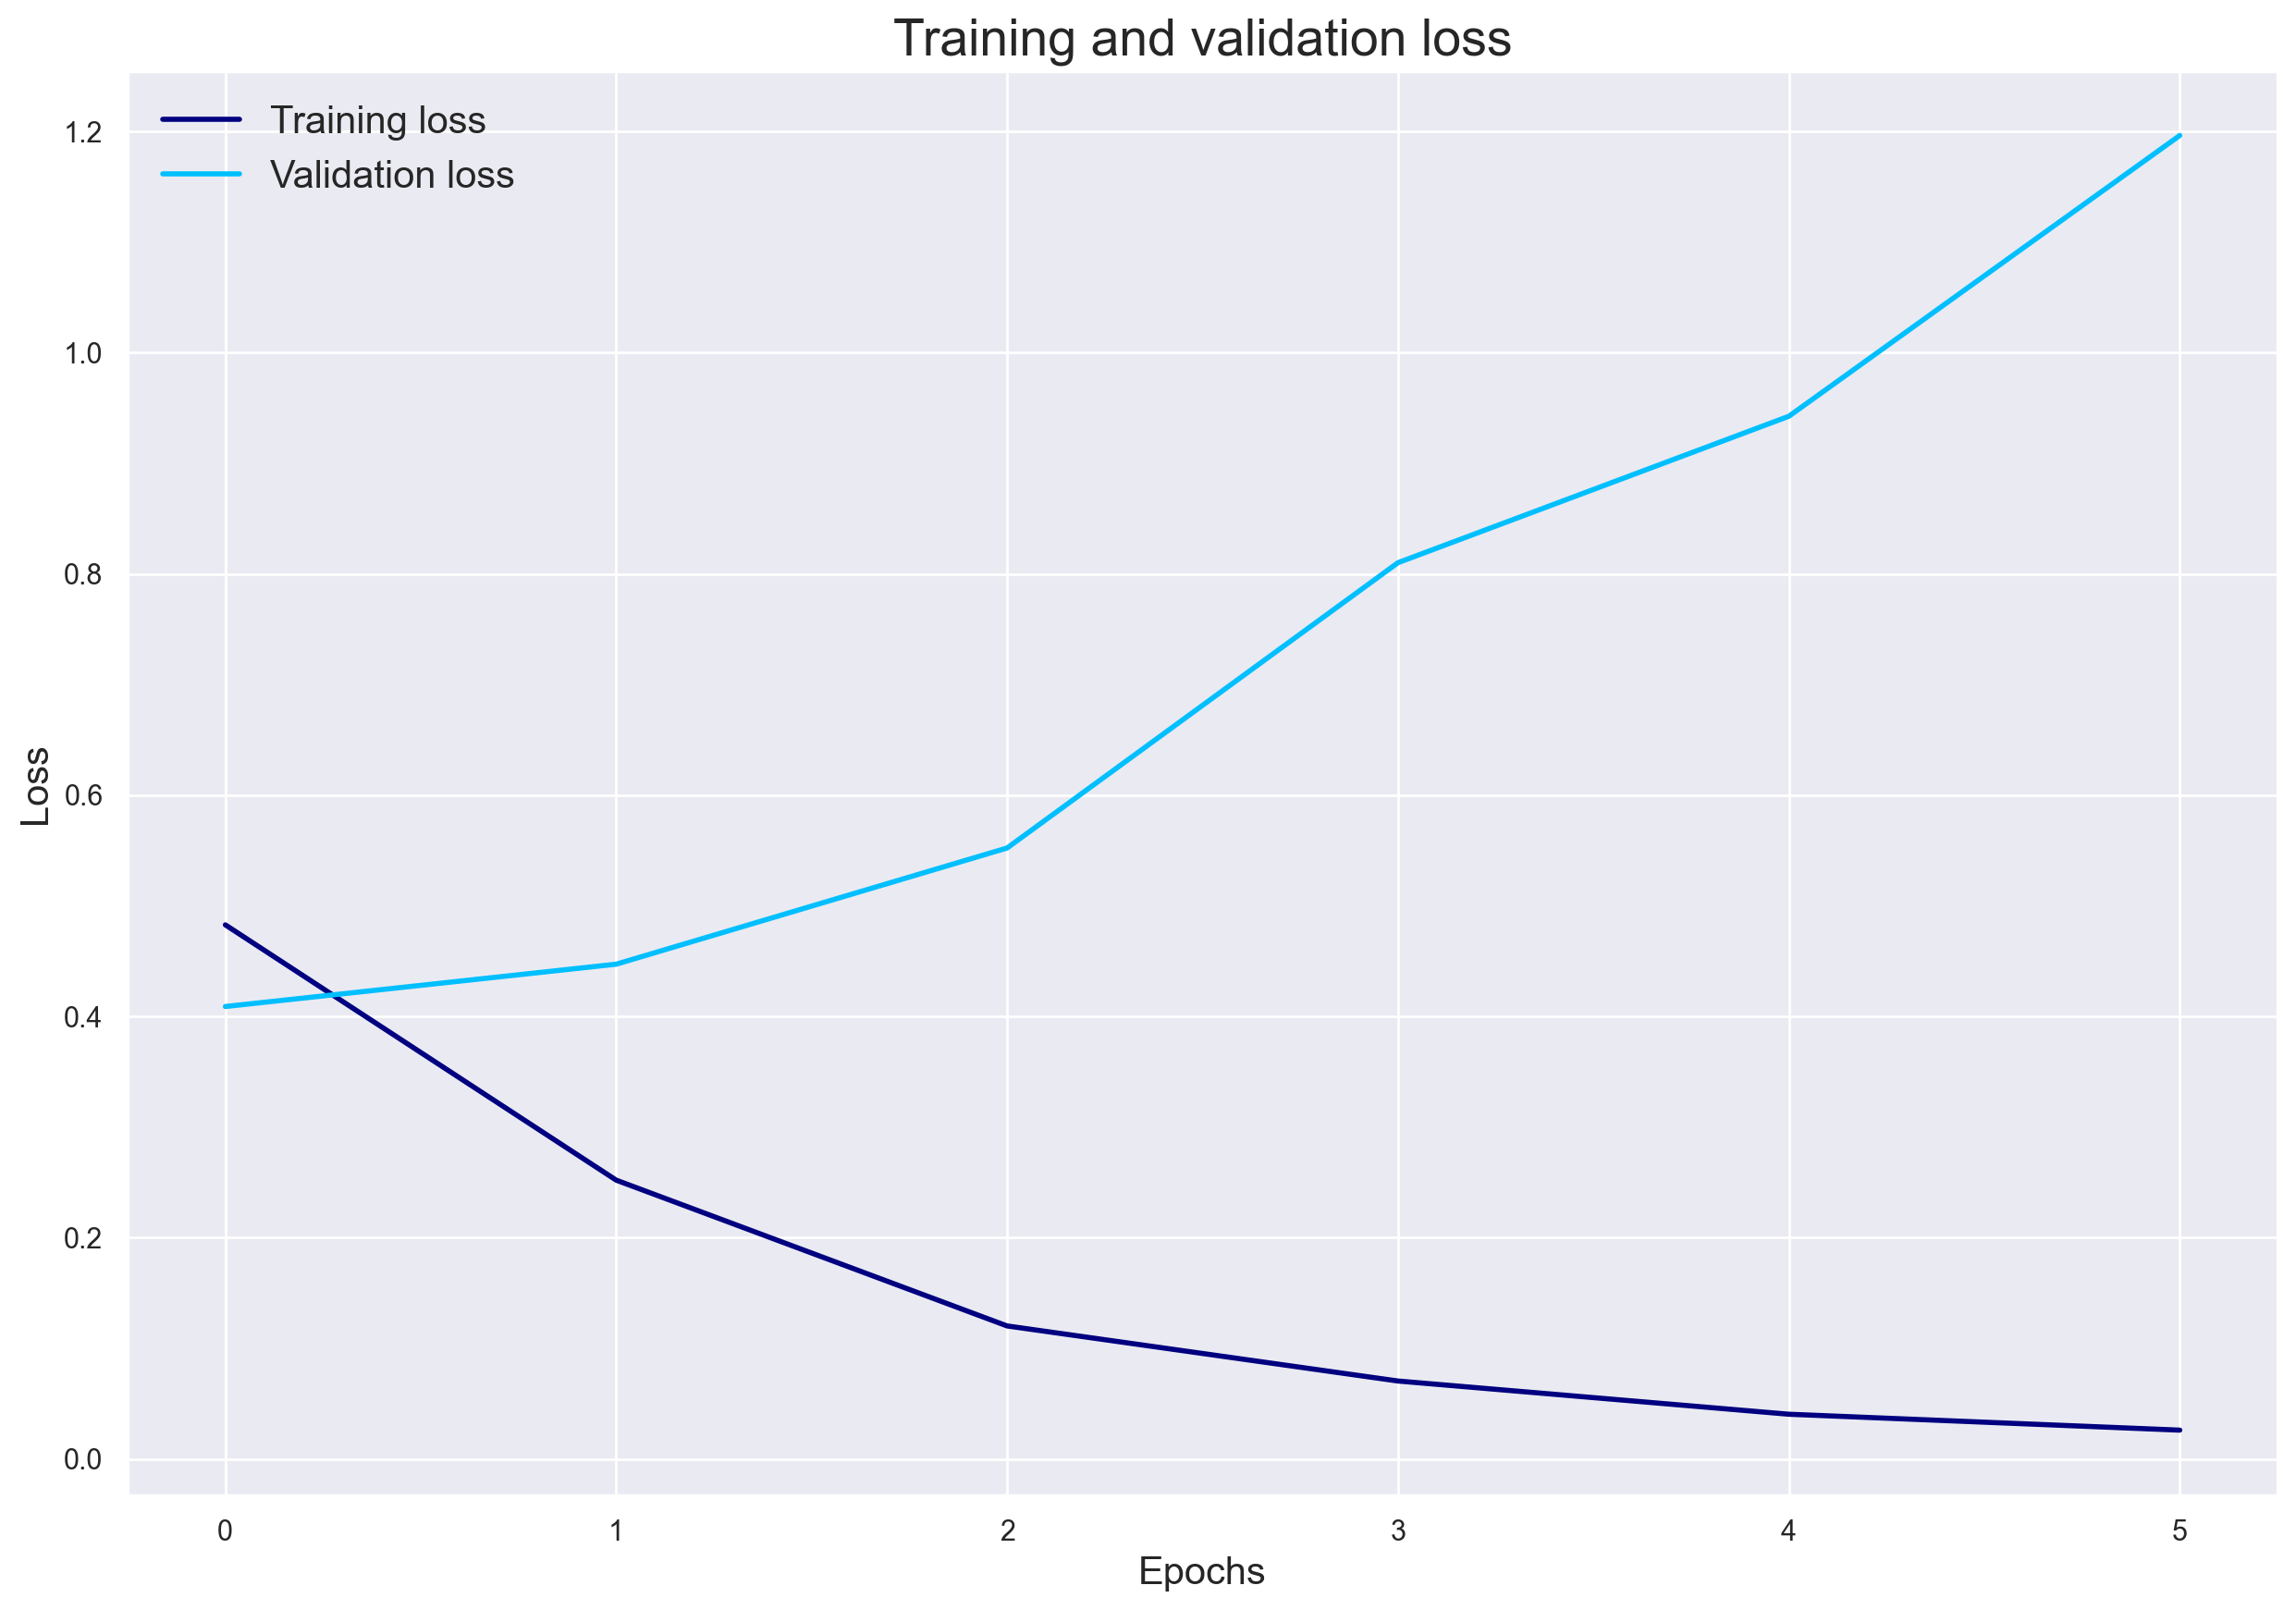

In [26]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss")

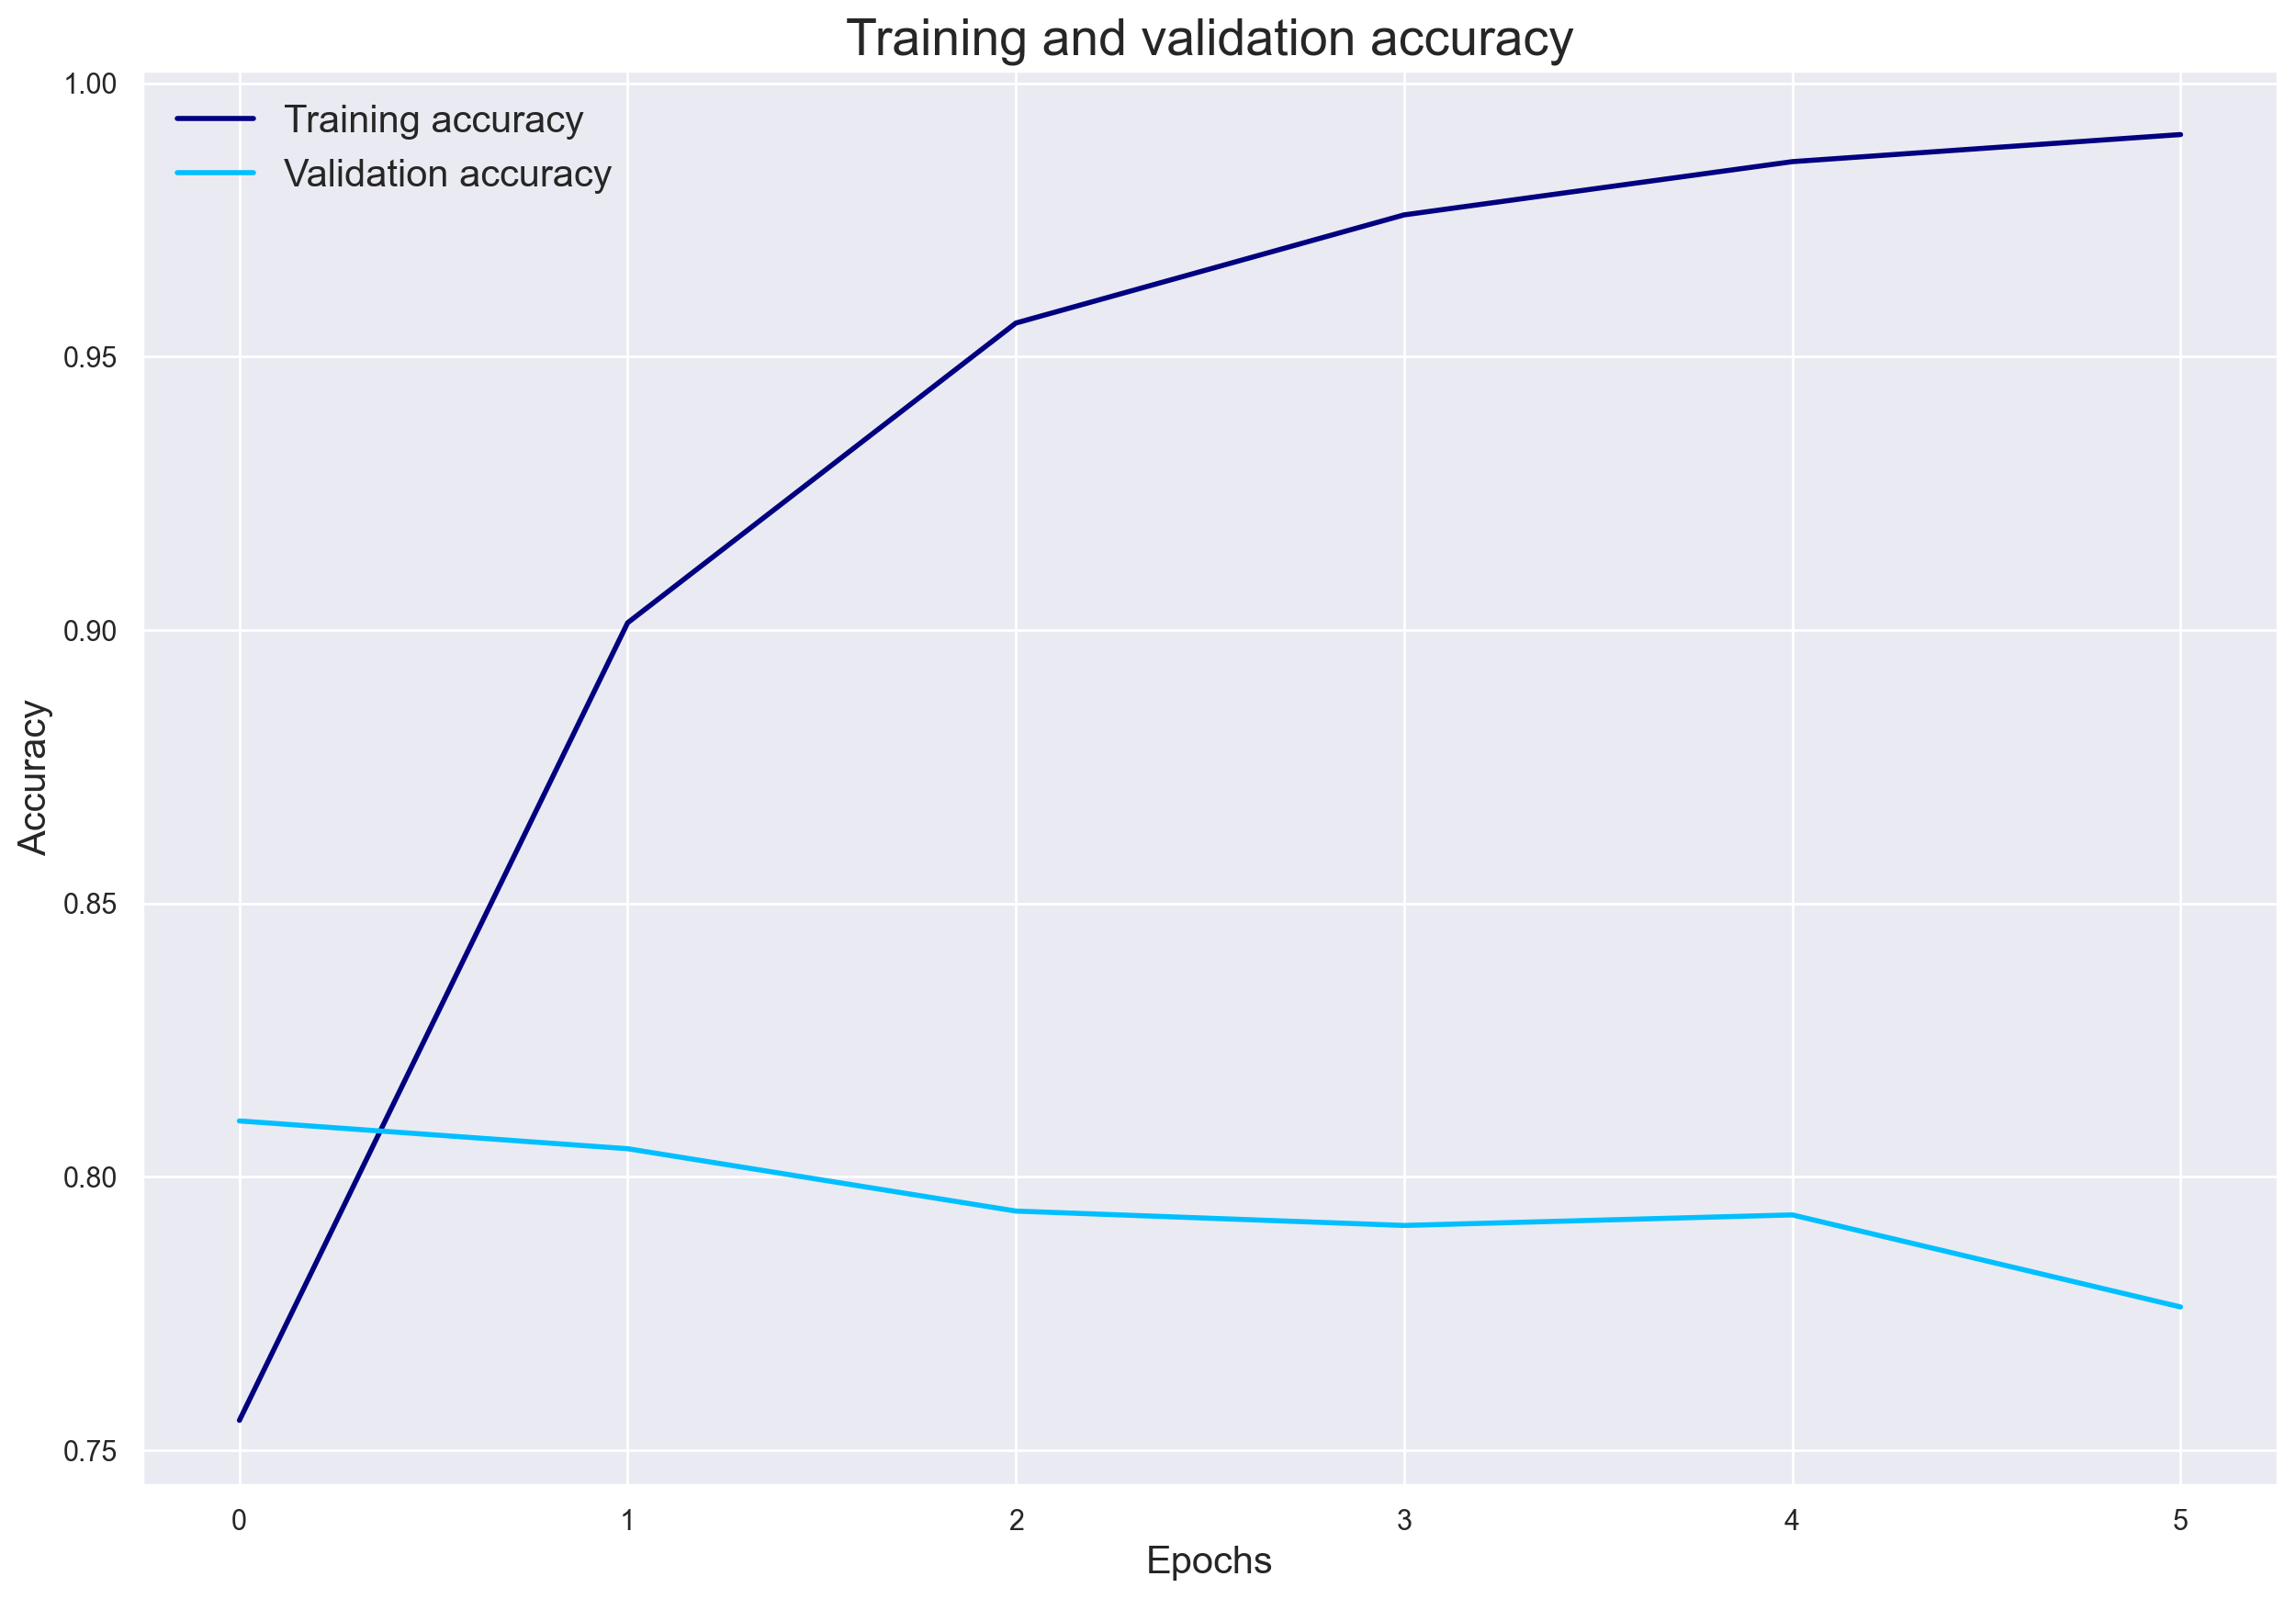

In [27]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy")